### **Projeto: Detecção de fraude em cartão de crédito**


---


Tradução e adaptação do código: Rodrigo da Costa Aglinskas

Projeto: Detecção de fraude em cartão de crédito

Desafio de projeto: Análise em Python com uso da biblioteca Pandas - DIO

Iniciado em 11/09/2021



### **Importando arquivos e bibliotecas**

In [21]:
# Importando as bibliotecas:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import six
import sys
sys.modules['sklearn.externals.six'] = six

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [22]:
# Configuração Pandas:

pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [23]:
# Leitura de arquivos:

#cc1_file = 'creditcard_sampledata.csv'

# arquivo original df com 147 MB
df = pd.read_csv('creditcard_fraud2.csv', error_bad_lines=False)
# Executando a amostra df3
df3 = pd.read_csv('amostraFraude.csv', error_bad_lines=False)

# dados não rotulados

banksim_file = 'banksim.csv'
banksim_adj_file = 'banksim_adj.csv'
# arquivos pickle:
db_full_file = 'db_full.pickle'
labels_file = 'labels.pickle'
labels_full_file = 'labels_full.pickle'
x_scaled_file = 'x_scaled.pickle'
x_scaled_full_file = 'x_scaled_full.pickle'

# Fraud detection using text

enron_emails_clean_file = 'enron_emails_clean.csv'
cleantext_file = 'cleantext.pickle'
corpus_file = 'corpus.pickle'
dict_file = 'dict.pickle'
ldamodel_file = 'ldamodel.pickle'


### **Tratando os dados**

In [24]:
# Criando uma amostra de 10% do df original
# df2 = df.sample(frac=0.10)

In [25]:
# Baixando a amostra
# df2.to_csv('amostraFraude.csv', encoding='utf-8', index=False)

In [26]:
# Verificando a estrutura do dataframe
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28679 entries, 0 to 28678
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  28679 non-null  int64  
 1   V1          28679 non-null  float64
 2   V2          28679 non-null  float64
 3   V3          28679 non-null  float64
 4   V4          28679 non-null  float64
 5   V5          28679 non-null  float64
 6   V6          28679 non-null  float64
 7   V7          28679 non-null  float64
 8   V8          28679 non-null  float64
 9   V9          28679 non-null  float64
 10  V10         28679 non-null  float64
 11  V11         28679 non-null  float64
 12  V12         28679 non-null  float64
 13  V13         28679 non-null  float64
 14  V14         28679 non-null  float64
 15  V15         28679 non-null  float64
 16  V16         28679 non-null  float64
 17  V17         28679 non-null  float64
 18  V18         28679 non-null  float64
 19  V19         28679 non-nul

In [27]:
df3.dtypes

Unnamed: 0      int64
V1            float64
V2            float64
V3            float64
V4            float64
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V17           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class          object
dtype: object

In [28]:
#df["V4"] = pd.to_numeric(df["V4"], downcast="float")
# Convertendo coluna Class de object para int

# df3['Class'] = pd.to_numeric(df3['Class'])

# ERRO: ValueError: Unable to parse string "1'" at position 201

In [29]:
# Localizando os valores com problema:

df3.loc[df3['Class']=="1'"]

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
201,28143,-27.143678,15.365804,-28.407424,6.370895,-20.087878,-4.666313,-18.709479,17.903574,-3.722279,-8.120962,4.419943,-6.210941,1.063837,-5.843528,-0.108836,-5.606597,-11.756256,-4.714947,0.783578,1.703888,1.796826,-1.960974,-0.902247,0.144011,2.024388,-0.204214,1.332153,0.385891,99.99,1'
323,152058,-3.576362,3.299436,-7.460433,7.783634,-0.398549,-1.968441,-3.110476,-0.328404,-1.574363,-2.497561,4.604170,-9.001915,-1.276324,-13.969471,1.256945,-4.491629,-5.969987,-1.274666,1.147784,-0.181455,0.540731,0.719526,0.379249,-0.616962,-0.442811,0.359841,-2.651825,0.422184,1.00,1'
861,110087,1.934946,0.650678,-0.286957,3.987828,0.316052,-0.099449,-0.021483,-0.172327,0.508730,1.072955,-0.427567,-2.777649,1.637140,1.571080,-1.445367,0.908650,-0.122016,-0.104110,-1.684022,-0.344452,-0.173602,-0.190974,0.219976,-0.216597,-0.136692,-0.129954,-0.050077,-0.051082,1.00,1'
1250,102676,-5.552122,5.678134,-9.775528,8.416295,-4.409844,-1.506235,-6.899839,3.750443,-3.879793,-6.864164,7.051065,-10.137529,2.815440,-9.909168,-0.262230,-5.022557,-8.522975,-2.012939,1.525732,-0.064780,1.128472,0.228484,0.286258,-0.536294,-0.104925,0.420919,-0.297557,-0.946184,119.74,1'
1627,143434,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,-5.653638,3.942316,-5.883724,-1.347814,-9.266120,-2.459556,-2.205644,-5.709087,-1.113937,-1.556530,0.164288,0.727415,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1.00,1'
1963,102480,-1.929597,4.066413,-4.865184,5.898602,-0.552493,-1.555962,-3.833623,0.679512,-3.463765,-6.683689,7.021278,-11.102493,1.711755,-10.447633,-2.799076,-6.261741,-11.647158,-3.451436,-0.507537,0.942489,1.137212,0.674245,-0.531765,-0.433409,0.378659,0.198107,0.869694,0.228048,0.00,1'
2271,148479,-1.541678,3.846800,-7.604114,3.121459,-1.254924,-2.084875,-2.385027,1.471140,-2.530507,-5.175660,1.927186,-6.011155,-1.195601,-6.745561,-0.058091,-4.325132,-5.558067,-1.580531,0.971906,0.114760,1.096405,1.064222,0.065370,0.257209,-0.693654,-0.335702,0.577052,0.398348,122.68,1'
2353,133184,-1.212682,-2.484824,-6.397186,3.670562,-0.863375,-1.855855,1.017732,-0.544704,-1.703378,-3.739659,1.738124,-2.844449,0.765864,-4.799737,-0.011335,-2.693168,-3.166955,-1.067800,-0.559132,2.908374,1.396872,0.092073,-1.492882,-0.204227,0.532511,-0.293871,0.212663,0.431095,1335.00,1'
2562,153653,-5.192496,3.164721,-5.047679,2.246597,-4.011781,-0.638908,-2.873463,1.576318,-2.861986,-2.120458,1.863596,-3.620252,-1.480714,-1.583343,-1.230469,-1.202298,-6.167637,-2.651539,0.013588,-1.850470,1.167244,-1.006617,0.774562,0.063397,-0.390658,1.884741,-1.742558,-0.082216,247.86,1'
2659,41397,-14.970346,8.401421,-16.867238,8.252334,-13.565130,-2.782438,-14.263735,9.643419,-7.701499,-14.226698,5.610999,-11.793979,1.598387,-11.606970,-0.044180,-9.286955,-19.899726,-7.518051,1.243517,-1.614660,2.714045,-0.101355,-0.439666,0.519514,0.789328,0.064357,-1.621386,-1.104819,273.01,1'


In [30]:
# erro: valores estão como 1', substituindo por 1:

df3['Class']= df3['Class'].replace(["1'"],["1"])

In [31]:
# Tentando novamente converter coluna Class de object para int

df3['Class'] = pd.to_numeric(df3['Class'])

# Agora funcionou.

In [32]:
# Checando os tipos:

df3.dtypes

Unnamed: 0      int64
V1            float64
V2            float64
V3            float64
V4            float64
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V17           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class           int64
dtype: object

In [33]:
df3.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,165825,2.009861,-0.869738,-1.754567,-0.423925,-0.186998,-0.756014,0.067375,-0.372006,-0.675936,0.841376,-1.173789,0.041871,0.501777,0.204775,-0.207727,-1.730563,-0.038104,0.588551,-0.531336,-0.358859,-0.451073,-0.949828,0.189053,0.581766,-0.152222,0.484464,-0.095600,-0.042231,113.96,0
1,146492,-1.804326,1.504552,-0.233085,-1.229363,1.502214,-0.347973,2.406507,-1.635108,2.463650,4.251623,1.835383,0.484691,0.557624,-1.710859,0.174277,-1.041797,-1.570204,0.131513,0.051017,1.408423,-0.299683,1.489198,-0.243334,0.744379,-0.480553,-0.435355,0.128771,-0.350759,44.99,0
2,96364,-0.826149,0.687367,0.833079,-0.538347,0.039801,0.080615,-0.206940,0.513953,1.749362,-1.191956,-1.421861,-2.980938,1.457096,1.406513,-0.710242,0.673623,-0.008299,0.930974,-0.226166,-0.023124,0.102609,0.576929,-0.246134,-1.012641,-0.208986,0.625561,0.218520,0.119810,29.99,0
3,120477,2.098926,0.318974,-2.724961,0.394636,1.246655,-0.707107,0.649341,-0.299002,-0.180722,-0.151160,0.755647,0.610829,0.035880,-0.528841,-0.871319,0.101675,0.360497,0.479553,0.384748,-0.138251,0.054431,0.311851,-0.107287,0.167923,0.483469,0.510968,-0.093167,-0.062508,5.95,0
4,86469,2.183102,-1.566933,-0.515539,-1.662056,-1.455993,-0.221062,-1.400477,-0.007258,-1.245094,1.663325,0.382201,0.017236,0.821759,-0.482807,-0.631955,0.076368,-0.059152,0.446303,0.312842,-0.314990,-0.358131,-0.652055,0.359658,-0.553220,-0.580116,-0.478611,0.028788,-0.042655,50.70,0


In [34]:
df3.tail()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
28674,128662,-0.294122,1.123794,0.040958,-0.665765,1.281603,-0.162226,1.105000,-0.192295,-0.169560,-0.471611,-1.338463,0.717218,1.702484,-0.151829,-0.063187,-0.424049,-0.611863,-0.366802,0.819757,0.162406,-0.214339,-0.388622,-0.067642,0.044649,-0.317071,-0.578125,0.296198,0.258734,1.51,0
28675,34756,0.861545,-1.065624,0.672919,0.570590,-1.205622,0.270839,-0.673109,0.221099,-0.896328,0.910822,1.060932,0.067018,-0.761531,0.446580,0.763152,-1.066885,-0.262822,1.758951,-1.506077,-0.241190,-0.065595,-0.155664,-0.118910,-0.034928,0.180498,-0.303340,0.039835,0.054071,194.00,0
28676,163538,2.215685,-1.486828,-0.436634,-1.676735,-1.439594,-0.110422,-1.507187,0.080852,-1.244714,1.677778,0.770808,-0.013614,0.454077,-0.415370,-0.596509,-0.035197,0.118078,0.345783,0.143921,-0.381301,-0.352085,-0.623079,0.488874,0.692703,-0.628297,-0.540289,0.028271,-0.036328,20.44,0
28677,25392,-0.829840,0.902751,1.101257,-0.707799,0.467336,-0.432122,0.870202,0.053977,-0.526561,-0.338157,1.086305,-0.117237,-1.712846,0.723435,-0.230119,0.156395,-0.500400,-0.187507,-0.845804,-0.319004,0.136557,0.188836,-0.150558,-0.002626,-0.155511,0.151353,-0.228816,0.097313,7.39,0
28678,62148,0.558709,-1.662584,0.547547,-1.199303,-1.550289,-0.166150,-0.435430,0.141454,1.741713,-1.235611,1.665720,1.461313,-0.324424,0.143366,0.982897,-0.582065,0.059827,0.302927,0.474186,0.516672,0.399864,0.691597,-0.346612,0.304658,0.254879,-0.019036,0.004588,0.067589,321.42,0


In [35]:
# o df tem valores com NaN
# Substituindo por zero:

df3 = df3.replace(np.nan, 0)

### **Verificando a relação fraude x não fraude**

In [36]:
# Conta ocorrências de fraude and não fraude e imprime:

occ = df3['Class'].value_counts()
occ

0    28622
1       57
Name: Class, dtype: int64

In [37]:
# Imprime a Razão de casos de fraude em relação ao total:

ratio_cases = occ/len(df3.index)
print(f'Razão de ocorrências de fraude: {ratio_cases[1]}\nRazão de ocorrências não fraudulentas: {ratio_cases[0]}')

Razão de ocorrências de fraude: 0.001987516998500645
Razão de ocorrências não fraudulentas: 0.9980124830014994


### **Visualização de dados**

In [38]:
# função preparando o df

def prep_data(df3: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df3.iloc[:, 1:28].values
    y = df3.Class.values
    return X, y

In [39]:
# Função cria um scatter plot dos dados e etiquetas
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [40]:
# Cria X e y da função prep_data
X, y = prep_data(df3)

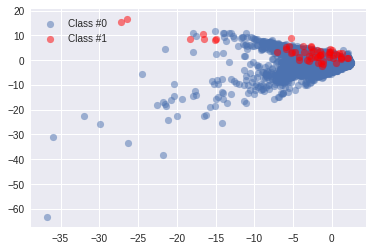

In [41]:
# Gerando gráfico dos dados pela função plot data em X and y
plot_data(X, y)

### **Reamostragem de dados: aumenta a detecção bem-sucedida**

In [42]:
# Undersampling  x Oversampling

# Implementando métodos de reamostragem usando o módulo Python imblean 

from imblearn.over_sampling import RandomOverSampler



# Define o método de reamostragem em treino e teste
method = SMOTE(kind='borderline1')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Aplica a reamostragem apenas aos dados de treinamento 
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

# Ajusta o modelo e obtém previsões
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Obtem métricas de desempenho do modelo
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5726
           1       0.09      0.70      0.16        10

    accuracy                           0.99      5736
   macro avg       0.54      0.84      0.58      5736
weighted avg       1.00      0.99      0.99      5736



In [43]:
# Métodos de reamostragem para dados desequilibrados
# Aplicando o Synthetic Minority Oversampling Technique (SMOTE)

# Executando a função prep_data
X, y = prep_data(df3)

In [44]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (28679, 27)
y shape: (28679,)


In [45]:
# Definindo o método de reamostragem
method = SMOTE()

In [46]:
# Cria um conjunto de recursos reamostrado 
X_resampled, y_resampled = method.fit_sample(X, y)

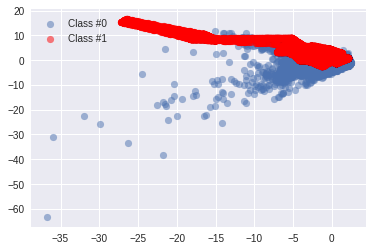

In [47]:
# Plotando os dados reamostrados 
plot_data(X_resampled, y_resampled)

In [48]:
df3 = df3.loc[:, df3.notnull().any(axis = 0)]

In [49]:
#Compare SMOTE to original data

pd.value_counts(pd.Series(y))

0    28622
1       57
dtype: int64

In [50]:
pd.value_counts(pd.Series(y_resampled))



1    28622
0    28622
dtype: int64

In [51]:
# Função compara o df original com o de reamostragem:

def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

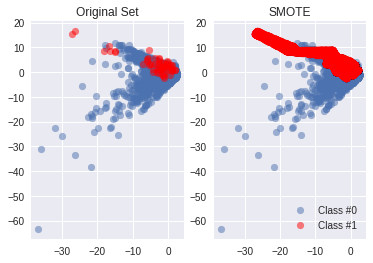

In [52]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

### **Algoritmos de detecção de fraude**

In [53]:
# Sistemas baseados em Machine Learning

# 1: divide os recursos e rótulos em dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = LinearRegression().fit(X_train, y_train)

In [55]:
# 2: Define o modelo a usar
model = LinearRegression()

In [56]:
# 3: Ajusta o modelo aos dados de treino
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
# 4: Obtém o modelo preditivo para os dados de teste
y_predicted = model.predict(X_test)

In [58]:
# 5: Compara y_test as previsões e obtém métricas de performance (r^2 score)
r2_score(y_test, y_predicted)

0.37698838242669364

In [59]:
# Método tradicional de detecção de fraude:

df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [60]:
df3.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.003815,0.005845,0.020565,0.004905,-0.002227,-0.002078,0.010797,0.006168,0.006361,0.012918,-0.006868,0.005639,0.002415,0.010903,0.001279,0.016298,0.011602,0.004340,-0.007331,0.003145,-0.004587,0.004447,0.001998,0.002444,-0.001304,-0.003552,-0.000548,0.000944,87.826572
1,-4.013088,3.308645,-6.190117,4.352649,-2.395297,-1.454933,-4.468554,0.984189,-2.387344,-4.866564,3.334521,-5.664783,-0.178809,-6.511112,-0.274369,-3.345101,-5.393370,-1.739826,0.261792,0.202952,0.898711,-0.190464,-0.453193,-0.115884,0.066830,0.130515,-0.023141,0.087371,139.452281


In [61]:
df3['flag_as_fraud'] = np.where(np.logical_and(df3.V1 < -3, df3.V3 < -5), 1, 0)

In [62]:
pd.crosstab(df3.Class, df3.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,28487,135
1,41,16


**Using ML classification to catch fraud**

In [63]:
# Criando conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [64]:
# Ajustando o modelo de regressão logístrica aos dados
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
# Obtendo modelos preditivos
predicted = model.predict(X_test)

In [66]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8584
           1       0.86      0.60      0.71        20

    accuracy                           1.00      8604
   macro avg       0.93      0.80      0.85      8604
weighted avg       1.00      1.00      1.00      8604

Confusion matrix:
 [[8582    2]
 [   8   12]]


**Regressão Logístrica com SMOTE**

In [67]:
# Definindo qual método de reamostragem e o modelo de ML do pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [68]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

**Pipelining**

In [69]:
# Separando os dados em X e y, em conjunto de treino e teste e ajustando o pipeline nos dados de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [70]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [71]:
# Obtendo os resultados do relatório de classificação e matriz de confusão 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      8584
           1       0.19      0.75      0.30        20

    accuracy                           0.99      8604
   macro avg       0.59      0.87      0.65      8604
weighted avg       1.00      0.99      0.99      8604

Confusion matrix:
 [[8518   66]
 [   5   15]]


### **Detecção de fraude usando dados rotulados**

In [18]:
# Criando uma amostra de 15% do df original
df4 = df.sample(frac=0.15)

# Baixando a amostra
df4.to_csv('amostraFraude2.csv', encoding='utf-8', index=False)

# tratando erro: valores estão como 0' e 1', substituindo por 0 e 1:
df4['Class']= df4['Class'].replace(["1'"],["1"])
df4['Class']= df4['Class'].replace(["0'"],["0"])

df4['Class'] = pd.to_numeric(df4['Class'])

df4.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
132117,79862.0,-0.434428,1.122242,1.721206,0.036081,-0.151561,-1.063572,0.773368,-0.138474,-0.553674,-0.338779,0.046026,0.535296,0.871022,-0.016847,0.725636,0.061013,-0.325632,-0.569198,-0.115367,0.143278,-0.196333,-0.460943,0.007162,0.717005,-0.207418,0.047965,0.271677,0.126207,2.69,0
58952,48621.0,-1.959629,1.790194,0.451016,-0.094612,-0.250511,-0.209614,-0.778990,-2.332526,-0.547001,-0.500325,-0.892629,0.624064,0.789798,0.507507,0.737241,0.582739,-0.354712,-0.245091,0.046471,0.569897,-1.538148,-0.211404,0.435627,-0.134296,-0.048089,0.082849,0.053776,0.085906,12.99,0
210487,138005.0,-2.561386,-1.911655,0.506972,-2.763369,1.225045,0.422278,-0.188736,0.662432,1.205817,-1.791214,0.846838,0.984005,-0.139387,0.246932,1.115213,-0.448372,-0.318922,-0.126976,-0.616626,-0.278696,0.318865,1.263473,0.676886,-1.600762,0.202965,-0.118351,-0.091816,-0.325516,109.81,0
13053,22914.0,-1.623366,0.711921,1.597481,0.175657,0.184294,-0.529087,1.460639,-0.765315,1.484808,0.221634,0.962655,-3.681433,-0.363614,1.505979,0.521310,-0.614894,0.734663,-0.474985,-0.510007,-0.283392,-0.308164,-0.179680,-0.329712,0.339958,0.255101,0.282263,-0.776408,-0.094990,116.72,0
142906,85009.0,-1.009890,1.138252,1.237909,0.861849,0.092237,-0.261061,0.556504,0.114137,-0.641934,-0.153224,-0.243018,0.032111,0.109635,0.356499,1.421501,-0.555711,0.185146,-0.381214,0.107293,-0.091677,0.108762,0.322035,-0.354499,0.098969,0.477620,-0.215094,-0.506640,-0.330995,28.98,0


In [72]:
# Visualizando o corpo do df4
X, y = prep_data(df4)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (42721, 27)
y shape: (42721,)


In [73]:
# listando o array
X[0, :]

array([-0.43442758,  1.12224227,  1.72120584,  0.03608051, -0.15156122,
       -1.06357186,  0.77336809, -0.13847441, -0.55367445, -0.33877946,
        0.04602626,  0.53529571,  0.87102231, -0.01684688,  0.72563646,
        0.06101255, -0.3256324 , -0.56919786, -0.11536713,  0.14327842,
       -0.19633315, -0.46094311,  0.00716237,  0.71700538, -0.20741806,
        0.04796521,  0.27167671])

In [74]:
# Contando valores separados pela classe
df4.Class.value_counts()

0    42656
1       65
Name: Class, dtype: int64

In [75]:
# Contando o número total de observações de y
total_obs = len(y)
total_obs

42721

In [76]:
# Contando o número total de observações de operações não fraudulentas 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
count_non_fraud

42656

In [77]:
# percentual de operações legítimas:
percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

99.85%


In [78]:
# Classificador de Floresta Aleatória - 1
# X_train, X_test, y_train, y_test
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [79]:
# Classificador de Floresta Aleatória - 2

# Ajustando o modelo ao conjunto de treino
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
# Obtendo predições para os dados de teste 
predicted = model.predict(X_test)

In [81]:
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
0.999


In [84]:
# Avaliação de performance
# Obtendo as métricas de performance pelo sklean
# importando os métodos
from sklearn.metrics import precision_recall_curve, average_precision_score

In [83]:
# Calcula a precisão média e a curva PR
average_precision = average_precision_score(y_test, predicted)

In [86]:
# Obtendo religação e precisão
# precision, recall = precision_recall_curve(y_test, predicted)

In [87]:
# Obtendo o modelo de probabilidades
probs = model.predict_proba(X_test)

In [89]:
# Visualizando ROC_AUC score usando probabilidades
# print(metrics.roc_auc_score(y_test, probs[:, 1]))

In [90]:
# Matriz de confusão e relatório de classificação¶
from sklearn.metrics import classification_report, confusion_matrix

In [91]:
# Obtendo predições
predicted = model.predict(X_test)

In [92]:
# Imprime o relatório de classificação usando predições
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.67      0.56      0.61        18

    accuracy                           1.00     12817
   macro avg       0.83      0.78      0.80     12817
weighted avg       1.00      1.00      1.00     12817



In [93]:
# Imprime a matriz de confusão usando predições
print(confusion_matrix(y_test, predicted))

[[12794     5]
 [    8    10]]


In [95]:
# Métricas de performance para o modelo RF

# Obtendo predições do modelo de floresta aleatória 
predicted = model.predict(X_test)

In [98]:
# Prevendo probabilidades
probs = model.predict_proba(X_test)

In [99]:
# Imprime a curva ROC, reporte de classificação e matriz de confusão
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9956159769426431

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.67      0.56      0.61        18

    accuracy                           1.00     12817
   macro avg       0.83      0.78      0.80     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12794     5]
 [    8    10]]


In [101]:
#  Plotando a Precisão the Precision vs. Recall Curve

# Calcula a precisão média e a curva PR
average_precision = average_precision_score(y_test, predicted)
average_precision

0.3709945413932306

In [102]:
# Obtém a precisão e a religação (rechamada)
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: [0.00140438 0.66666667 1.        ]
Recall: [1.         0.55555556 0.        ]


In [107]:
# criando a função de recall e precisão:

def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Curva Precision-Recall: AP={average_precision:0.2f}')
    return plt.show()

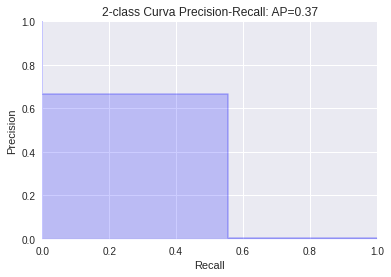

In [108]:
# Plota a recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

The AUROC answers the question: "How well can this classifier be expected to perform in general, at a variety
of different baseline probabilities?" but precision and recall don't. #The ROC curve plots the true positives vs.
 false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes 
 a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better 
 than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is
  larger), they have better expected performance. 

In [109]:
# Ajustando os pesos do algorítmo
# Ajustes de modelo

# Define o modelo com a sub-amostra balanceada
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5, n_estimators=100)

# Ajusta o modelo de treino com o conjunto de treino
model.fit(X_train, y_train)

# Obtém os valores preditivos e probabilidades do modelo 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Imprime a curva ROC, relatório de classificação e matriz de confusão
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9421851533539947

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.69      0.50      0.58        18

    accuracy                           1.00     12817
   macro avg       0.85      0.75      0.79     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12795     4]
 [    9     9]]


In [110]:
# Adjusting RF for fraud detection
# Função de modelo sklearn

def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Ajusta o modelo de treino com o conjunto de treino
    model.fit(X_train, y_train)

    # Obtém os valores preditivos e probabilidades do modelo 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Imprime a curva ROC, relatório de classificação e matriz de confusão
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [111]:
# Alterando as opções do modelo
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Muda a profundidade do modelo: 
                               max_depth=10,
                               # Altera o número de amostras nos nós do intervalo 
                               min_samples_leaf=10, 
                               # Altera o número de árvores a utilizar
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)

# Executa a função get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9401559149586339

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.59      0.56      0.57        18

    accuracy                           1.00     12817
   macro avg       0.79      0.78      0.79     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12792     7]
 [    8    10]]


In [113]:
# Parametros de otimização com GridSearchCV

# Define o parametro conjunto para testar
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define o modelo a usar
model = RandomForestClassifier(random_state=5)

# Combina o conjunto de parâmetros com o modelo definido
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Ajusta o modelo aos dados de treino e obtém os melhores parâmetros
CV_model.fit(X_train, y_train)
CV_model.best_params_

In [114]:
# Modelo de resultados com GridSearchCV

# Inserindo os parâmetros de otimização no modelo
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Obtendo os resultados do modelo
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9433462683716609

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.69      0.61      0.65        18

    accuracy                           1.00     12817
   macro avg       0.84      0.81      0.82     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12794     5]
 [    7    11]]


In [115]:
# Métodos de conjuntos

# Regressão logística

# Define o modelo de regressão logística e ajustes
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, solver='liblinear')

# Obtém os resultados do modelo
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9874729796598692

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.43      0.72      0.54        18

    accuracy                           1.00     12817
   macro avg       0.72      0.86      0.77     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12782    17]
 [    5    13]]


In [116]:
# Classificador de votação

# Define os três classificadores a usar no conjunto
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=8, 
                              max_features='log2',
                              min_samples_leaf=10, 
                              n_estimators=30, 
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")

# Combina os classiificadores com o conjunto modelo
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Obtém os resultados 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.73      0.61      0.67        18

    accuracy                           1.00     12817
   macro avg       0.87      0.81      0.83     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12795     4]
 [    7    11]]


In [117]:
# Ajustas dos pesos com o Classificador de votação

# Define o conjunto modelo
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Obtém os resultados
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

ROC Score:
0.975501558281463

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12799
           1       0.67      0.56      0.61        18

    accuracy                           1.00     12817
   macro avg       0.83      0.78      0.80     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12794     5]
 [    8    10]]


### **Detecção de fraude usando dados não rotulados**

Origem dados:
https://github.com/banking-project/banksim

In [118]:
 # Exploring the data

banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv(banksim_adj_file)
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [119]:
banksim_df.shape

(7200, 5)

In [120]:
banksim_df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [121]:
banksim_adj_df.shape

(7189, 18)

In [122]:
banksim_adj_df.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [123]:
banksim_df.groupby(['category']).mean()

,amount,fraud
category,,
es_barsandrestaurants,43.841793,0.022472
es_contents,55.170000,0.000000
es_fashion,59.780769,0.020619
es_food,35.216050,0.000000
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_hotelservices,172.756245,0.548387
es_hyper,46.788180,0.125000
es_leisure,229.757600,1.000000


In [124]:
banksim_df.groupby(['age']).mean()

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


In [125]:
banksim_df.age.value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64

In [126]:
# Using statistics to define normal behavior

# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

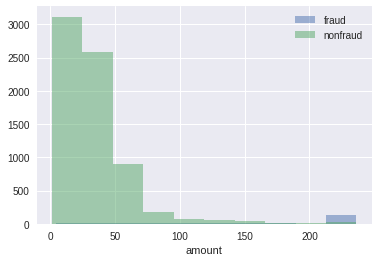

In [127]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

In [132]:
# Clustering methods to detect fraud

# Import the packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Transform and scale your data
X = np.array(df4).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the k-means model and fit to the data
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)

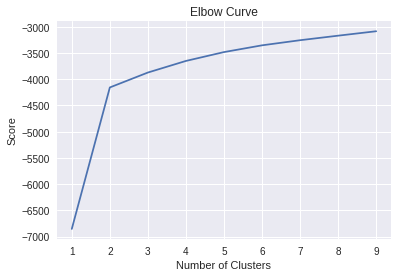

In [130]:
clust = range(1, 10) 
kmeans = [KMeans(n_clusters=i) for i in clust]

score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [133]:
# Scaling the data

labels = banksim_adj_df.fraud

In [134]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [135]:
# Take the float values of df for X
X = banksim_adj_df[cols].values.astype(np.float)

In [136]:
X.shape

(7189, 17)

In [137]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [138]:
# K-mean clustering

# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [139]:
# Elbow method

# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

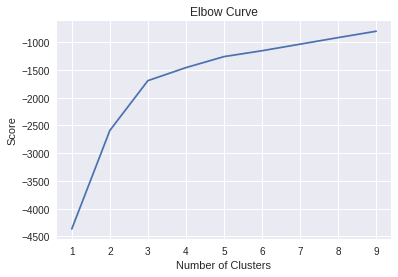

In [140]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [142]:
# Assigning fraud vs. non-fraud


# Flagging Fraud Based on Distance to Centroid

# Run the kmeans model on scaled data
kmeans = KMeans(n_clusters=6, random_state=42,n_jobs=-1).fit(X_scaled)

# Get the cluster number for each datapoint
X_clusters = kmeans.predict(X_scaled)

# Save the cluster centroids
X_clusters_centers = kmeans.cluster_centers_

# Calculate the distance to the cluster centroid for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Create predictions based on distance
km_y_pred = np.array(dist)
km_y_pred[dist>=np.percentile(dist, 93)] = 1
km_y_pred[dist<np.percentile(dist, 93)] = 0

In [143]:
# Detecting outliers

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [144]:
# Checking model results

def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [145]:
# Obtain the ROC score
roc_auc_score(y_test, km_y_pred)

0.8109115999408585

Confusion matrix, without normalization


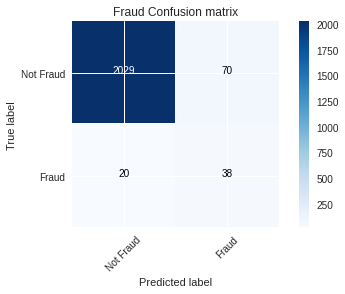

In [146]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

In [147]:
# Alternate clustering methods for fraud detection

# Implementation of DBSCAN

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1).fit(X_scaled)

In [148]:
# Get the cluster labels (aka numbers)
pred_labels = db.labels_

In [149]:
# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

In [150]:
# Print model results
print(f'Estimated number of clusters: {n_clusters_}')

Estimated number of clusters: 22


In [152]:
# Get sample counts in each cluster 
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

[3252  145 2714   55  174  119  122   98   54   13   76   43   25   51
   47   42   15   15   19   23   18   10]


In [153]:
# DB scan

# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

In [154]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


In [155]:
# Assessing smallest clusters

# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [156]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

In [157]:
# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [21 17  9]


In [158]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [10 15 15]


In [159]:
# Results verification

# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)

In [160]:
# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24


### **Fraud detection using text**

In [202]:
# Word counts to flag fraud with pandas
# Using a string operator to find words


In [200]:
# Word search with dataframes

df5 = pd.read_csv(enron_emails_clean_file)

In [219]:
mask = df5['clean_content'].str.contains('sell enron stock', na=False)

In [220]:
# Select the data from df using the mask
df5[mask]

,Message-ID,From,To,Date,content,clean_content,flag
154,<6336501.1075841154311.JavaMail.evans@thyme>,('sarah.palmer@enron.com'),('sarah.palmer@enron.com'),2002-02-01 14:53:35,\nJoint Venture: A 1997 Enron Meeting Belies O...,joint venture enron meeting belies officers cl...,1


In [221]:
# Using list of terms

# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select from df 
filtered_emails = df5[df5.clean_content.str.contains('|'.join(searchfor), na=False)]
filtered_emails.head()

,Message-ID,From,To,Date,content,clean_content,flag
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...,1
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...,1
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...,1
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...,1
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...,1


In [222]:
# Creating a flag

# Create flag variable where the emails match the searchfor terms
df5['flag'] = np.where((df5['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df5['flag'].value_counts()
print(count)

0    1776
1     314
Name: flag, dtype: int64


In [223]:
from nltk import word_tokenize
from nltk.corpus import stopwords 
import string

In [216]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [224]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [225]:
# Removing stopwords
# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to", "cc", "subject", "http", "from", "sent", "ect", "u", "fwd", "www", "com", 'html'))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

In [226]:
# Cleaning text data
# Import the lemmatizer from nltk
lemma = WordNetLemmatizer()

def clean(text, stop):
    text = str(text).rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

In [229]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [230]:
# Clean the emails in df and print results
text_clean=[]
for text in df5['clean_content']:
    text_clean.append(clean(text, stop).split()) 

In [231]:
text_clean[0][:10]

['investools',
 'advisory',
 'free',
 'digest',
 'trusted',
 'investment',
 'advice',
 'unsubscribe',
 'free',
 'newsletter']

In [ ]:
# Topic modeling on fraud

from gensim import corpora
import gensim

In [234]:
# Create dictionary and corpus
# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]

In [235]:
print(dictionary)

Dictionary(33980 unique tokens: ['account', 'accurate', 'acquiring', 'acre', 'address']...)


In [236]:
corpus[0][:10]

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 6),
 (6, 1),
 (7, 2),
 (8, 4),
 (9, 1)]

In [237]:
# LDA model

# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.013*"enron" + 0.008*"company" + 0.005*"e" + 0.005*"said" + 0.004*"new"')
(1, '0.013*"enron" + 0.011*"e" + 0.009*"mail" + 0.007*"message" + 0.007*"wj"')
(2, '0.033*"image" + 0.031*"td" + 0.024*"net" + 0.021*"money" + 0.020*"tr"')
(3, '0.008*"aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa" + 0.006*"customer" + 0.006*"font" + 0.006*"point" + 0.005*"seller"')
(4, '0.047*"enron" + 0.011*"hou" + 0.009*"pm" + 0.008*"message" + 0.008*"please"')


In [244]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 16.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 184 kB/s 
     |████████████████████████████████| 11.3 MB 53.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=9fbe0526a0bbcde353e795f87f3da050888408b0e69ac2835f3399f4503f3ff3
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take in

In [255]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [251]:
pyLDAvis.enable_notebook()

In [259]:
# Flagging fraud based on topic
# Using your LDA model results for fraud detection
# To understand topics, you need to visualize

# lda_display = gensimvis.prepare(ldamodel, corpus, dictionary, sort_topics=False)
# não funciona

In [261]:
# pyLDAvis.display(lda_display)

In [262]:
# Finding fraudsters based on topic

def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [263]:
# Run get_topic_details function and check the results
topic_details_df = get_topic_details(ldamodel, corpus)

In [264]:
topic_details_df.head()

,Dominant_Topic,% Score
0,0.0,0.944473
1,0.0,0.612993
2,4.0,0.784831
3,4.0,0.993498
4,4.0,0.993382


In [265]:
topic_details_df.tail()

,Dominant_Topic,% Score
2085,0.0,0.908290
2086,2.0,0.598205
2087,2.0,0.999322
2088,1.0,0.998143
2089,4.0,0.988462


In [266]:
# Add original text to topic details in a dataframe
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)

In [267]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).head()

,Dominant_Topic,% Score,Original text
442,0.0,0.999963,"[pleased, send, web, based, e, mail, alert, pr..."
135,0.0,0.999953,"[lawyer, agree, order, safeguard, document, ho..."
849,3.0,0.999877,"[original, message, received, thu, aug, cdt, e..."
2081,2.0,0.999631,"[unsubscribe, mailing, please, go, money, net,..."
281,0.0,0.999365,"[today, issuealert, sponsor, secure, scientech..."


In [268]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).tail()

,Dominant_Topic,% Score,Original text
2087,2.0,0.999322,"[image, image, image, image, image, image, ima..."
81,0.0,0.999210,"[brazil, scramble, energy, new, york, time, wo..."
1183,0.0,0.999194,"[requested, news, alert, amcc, follows, equity..."
33,0.0,0.999161,"[travelshorts, otc, bb, tlsh, latest, price, c..."
1444,0.0,0.999144,"[today, headline, new, york, time, web, wednes..."


In [269]:
# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0), 1, 0)

In [270]:
topic_details_1 = topic_details[topic_details.flag == 1]

In [271]:
topic_details_1.sort_values(by=['% Score'], ascending=False).head(10)

,Dominant_Topic,% Score,Original text,flag
849,3.0,0.999877,"[original, message, received, thu, aug, cdt, e...",1
653,3.0,0.995039,"[reservation, status, changed, received, see, ...",1
2057,3.0,0.994956,"[reservation, status, changed, detail, reserva...",1
2041,3.0,0.988875,"[please, read, ur, thought, hear, guy, coming,...",1
2049,3.0,0.986004,"[think, lucci, updated, email, copy, submitted...",1
2061,3.0,0.981212,"[completely, forgot, trip, vega, bet, ha, ha, ...",1
2028,3.0,0.978211,"[get, wilkerson, hightower, top, nationally, d...",1
2078,3.0,0.977811,"[paul, wondering, getting, lng, industry, repo...",1
2011,3.0,0.974658,"[kim, spoke, andrew, gregoricj, asarco, today,...",1
2035,3.0,0.941396,"[hello, greg, belated, congrats, new, post, en...",1


### **Referências:**

https://www.teses.usp.br/teses/disponiveis/45/45134/tde-01022016-204144/publico/Paulo_Oliveira_Mestrado_PPGCC.pdf

https://towardsdatascience.com/understand-and-build-fp-growth-algorithm-in-python-d8b989bab342

https://trenton3983.github.io/files/projects/2019-07-19_fraud_detection_python/2019-07-19_fraud_detection_python.html

people described by a set of attributes as good or bad credit risks.
https://www.openml.org/d/31

creditcard fraud  in September 2013 by european cardholders
https://www.openml.org/d/42175
https://www.openml.org/d/1597

https://minerandodados.com.br/tres-tecnicas-de-amostragem-de-dados-utilizando-python/

https://www.kaggle.com/vmeh23/general-data-analysis-for-banksim-data-set

https://www.kaggle.com/kartik2112/fraud-detection-banksim?select=bs140513_032310.csv